# ML v1: Gaussian Process Classification for Snow Cover
Tony Cannistra | Feb 2018

----
Work in a [previous notebook](./data-exploration.ipynb#GPC-With-RBF-Kernel?) has shown that a well-optimized Gaussian Process classifier with an RBF kernel can produce ~96% accuracy on these data. In this notebook we're going to develop a training pipieline for this classifier, produce some performance metrics and plots, and attempt to demonstrate visually the results of a well-trained classifier on an actual image. 

In [253]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from functools import partial
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.gaussian_process import GaussianProcessClassifier, kernels
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib

# need parallelism for training
from multiprocessing import Pool
_pool = Pool(processes=5)

# configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [136]:
# start with raw luminance
snowOnFile  = "../images/snow/PROVISIONAL_snow_datatable.csv"
snowOffFile = "../images/no-snow/PROVISIONAL_nosnow_datatable.csv"
snowOnData  = pd.read_csv(snowOnFile)
snowOffData = pd.read_csv(snowOffFile)

In [137]:
# add class labels
snowOnData['label'] = 1
snowOffData['label'] = 0

In [144]:
# merge and shuffle
data = pd.concat([snowOnData, snowOffData], axis=0)
data = data.sample(frac=1)
print("{:d} | 0: {:d}, 1: {:d}".format(len(data),
                                      len(data[data.label == 0]), 
                                      len(data[data.label == 1])))

2650 | 0: 1545, 1: 1105


## Model Evaluation
We'll scale the data first. 

In [142]:
bands = ['band1', 'band2', 'band3', 'band4']
X = np.array(data[bands])
y = np.array(data.label)
X = StandardScaler().fit_transform(X)

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [148]:
# we'll define the different classifiers to  test here. 
simple_gpc = {
    'n_jobs' : -1, # use threads
}

kernel_gpc_noopt = {
    'n_jobs'    : -1, 
    'kernel'    : 1.0 * kernels.RBF(length_scale=1.0),
    'optimizer' : None
}

kernel_gpc_opt = {
    'n_jobs' : -1, 
    'kernel' : 1.0 * kernels.RBF(length_scale=1.0)
    # default optimizer
}

paramsets = [kernel_gpc_opt]#, kernel_gpc_noopt, kernel_gpc_opt]

In [149]:
accuracies = []
folder = StratifiedKFold(5)
for params in paramsets:
    gpc = GaussianProcessClassifier(**params)
    acc = cross_val_score(gpc, X, y, cv=folder, n_jobs=-1)
    accuracies.append(np.mean(acc))
        

In [153]:
accuracies

[0.9615094339622642]

That's **96% accuracy** averaged across 5-fold cross validation. Pretty neat. Let's train on all of the data and save the resulting model. 

## Training + Persistence

In [261]:
model_outfile_name = "snowcover-model.pkl"
model_params = kernel_gpc_opt
#model = GaussianProcessClassifier(**model_params)
#model.fit(X, y)
#joblib.dump(model, model_outfile_name)
model = joblib.load(model_outfile_name)

In [262]:
!du -hc snowcover-model.pkl

54M	snowcover-model.pkl
54M	total


## Some Inspection + Plots

In [263]:
_, snowOnProbs = zip(*model.predict_proba(X))

Text(0.5,0.98,'GPC Probabilistic Performance')

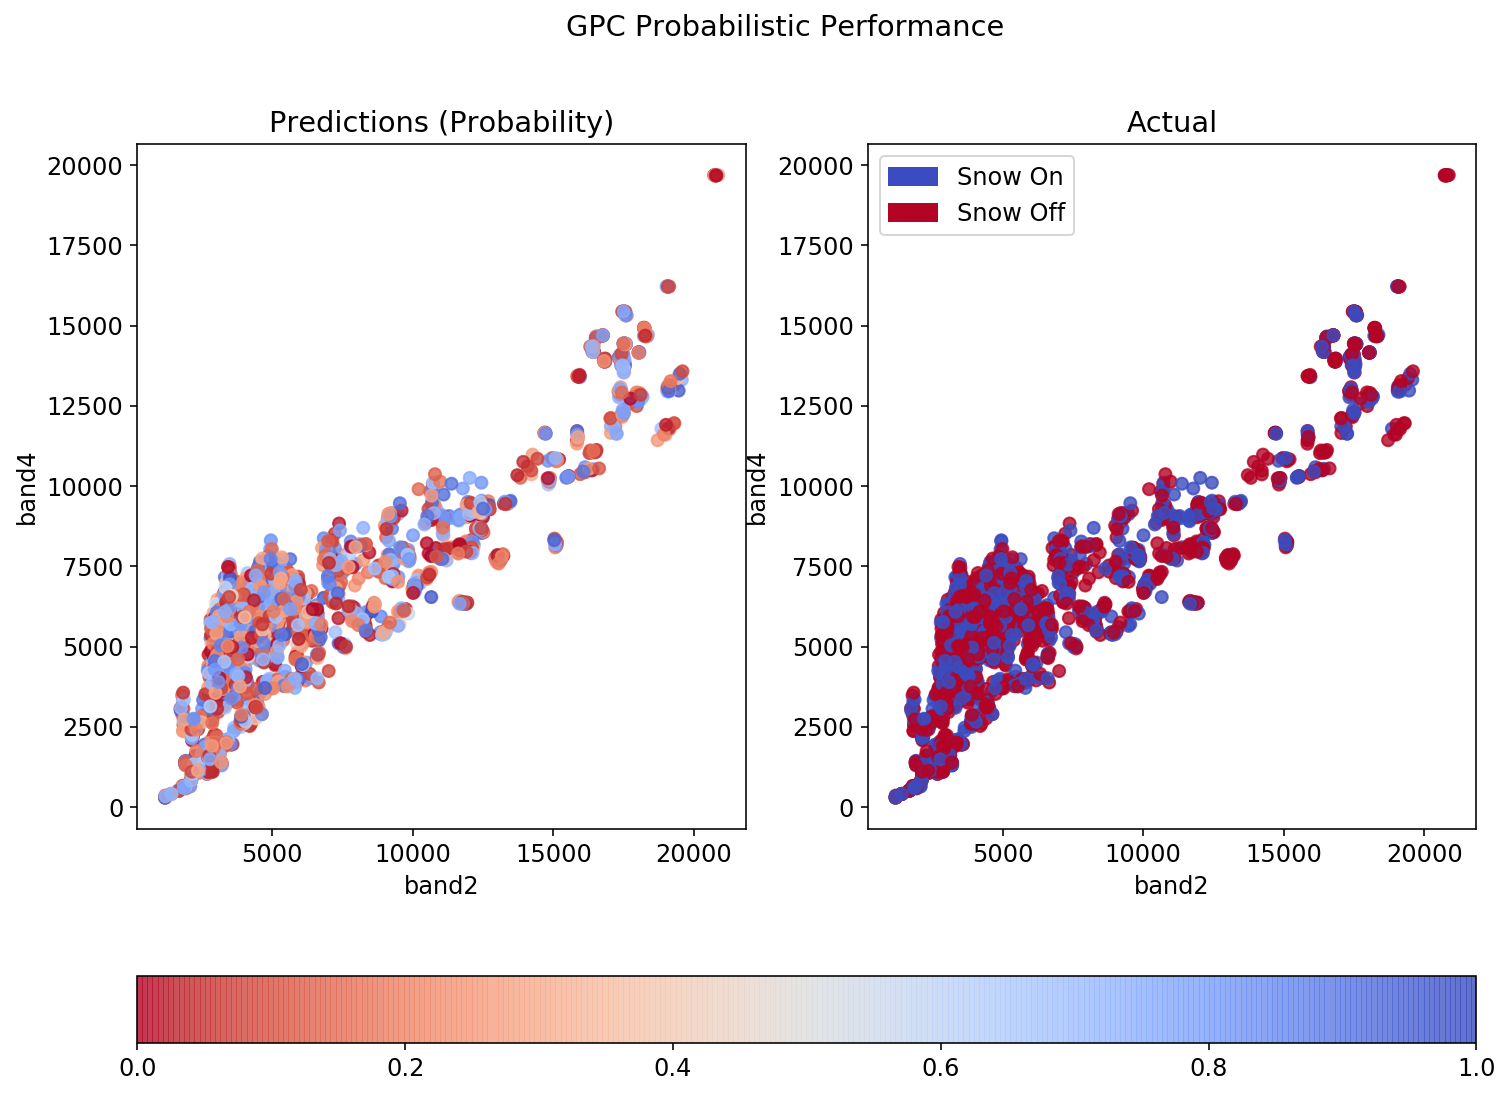

In [275]:
# which bands to plot?
b1 = 'band2'
b2 = 'band4'
preds = snowOnProbs

cmap = plt.get_cmap("coolwarm_r")

binary_colors = np.array([cmap(0), cmap(1)])

fig, axes = plt.subplots(1, 2)
ax1, ax2 = axes
s1 = ax1.scatter(data[b1], data[b2], c = preds, cmap=cmap, alpha=0.8, vmin=0, vmax=1)
ax1.set_title("Predictions (Probability)")
ax1.set_xlabel(b1)
ax1.set_ylabel(b2)
fig.colorbar(s1, orientation='horizontal', ax=axes.ravel().tolist())

ax2.scatter(data[b1], data[b2], c = y, cmap=cmap, alpha=0.8)
ax2.set_title("Actual")
ax2.set_xlabel(b1)
ax2.set_ylabel(b2)

nosnow_patch = patches.Patch(color=cmap(0.999999), label="Snow On")
snow_patch = patches.Patch(color=cmap(0), label='Snow Off')

#ax1.legend(handles=[nosnow_patch, snow_patch])
ax2.legend(handles=[nosnow_patch, snow_patch])

# incorrect = abs(preds - merged.label)
# ax3.set_title("Mistakes")
# ax3.scatter(merged[b1], merged[b2], color=colors[incorrect], alpha=0.9)
# right_patch = patches.Patch(color=colors[0], label="Correct")
# wrong_patch = patches.Patch(color=colors[1], label='Incorrect')

# ax1.legend(handles=[nosnow_patch, snow_patch])
# ax2.legend(handles=[nosnow_patch, snow_patch])
# ax3.legend(handles=[right_patch, wrong_patch])

fig.suptitle("GPC Probabilistic Performance")
#plt.tight_layout(w_pad=0.9)



In [276]:
actualPreds =  model.predict(X)
accuracy = accuracy_score(y, actualPreds)

Text(0.5,0.98,'GPC Threshold Performance (acc: 99.207547)')

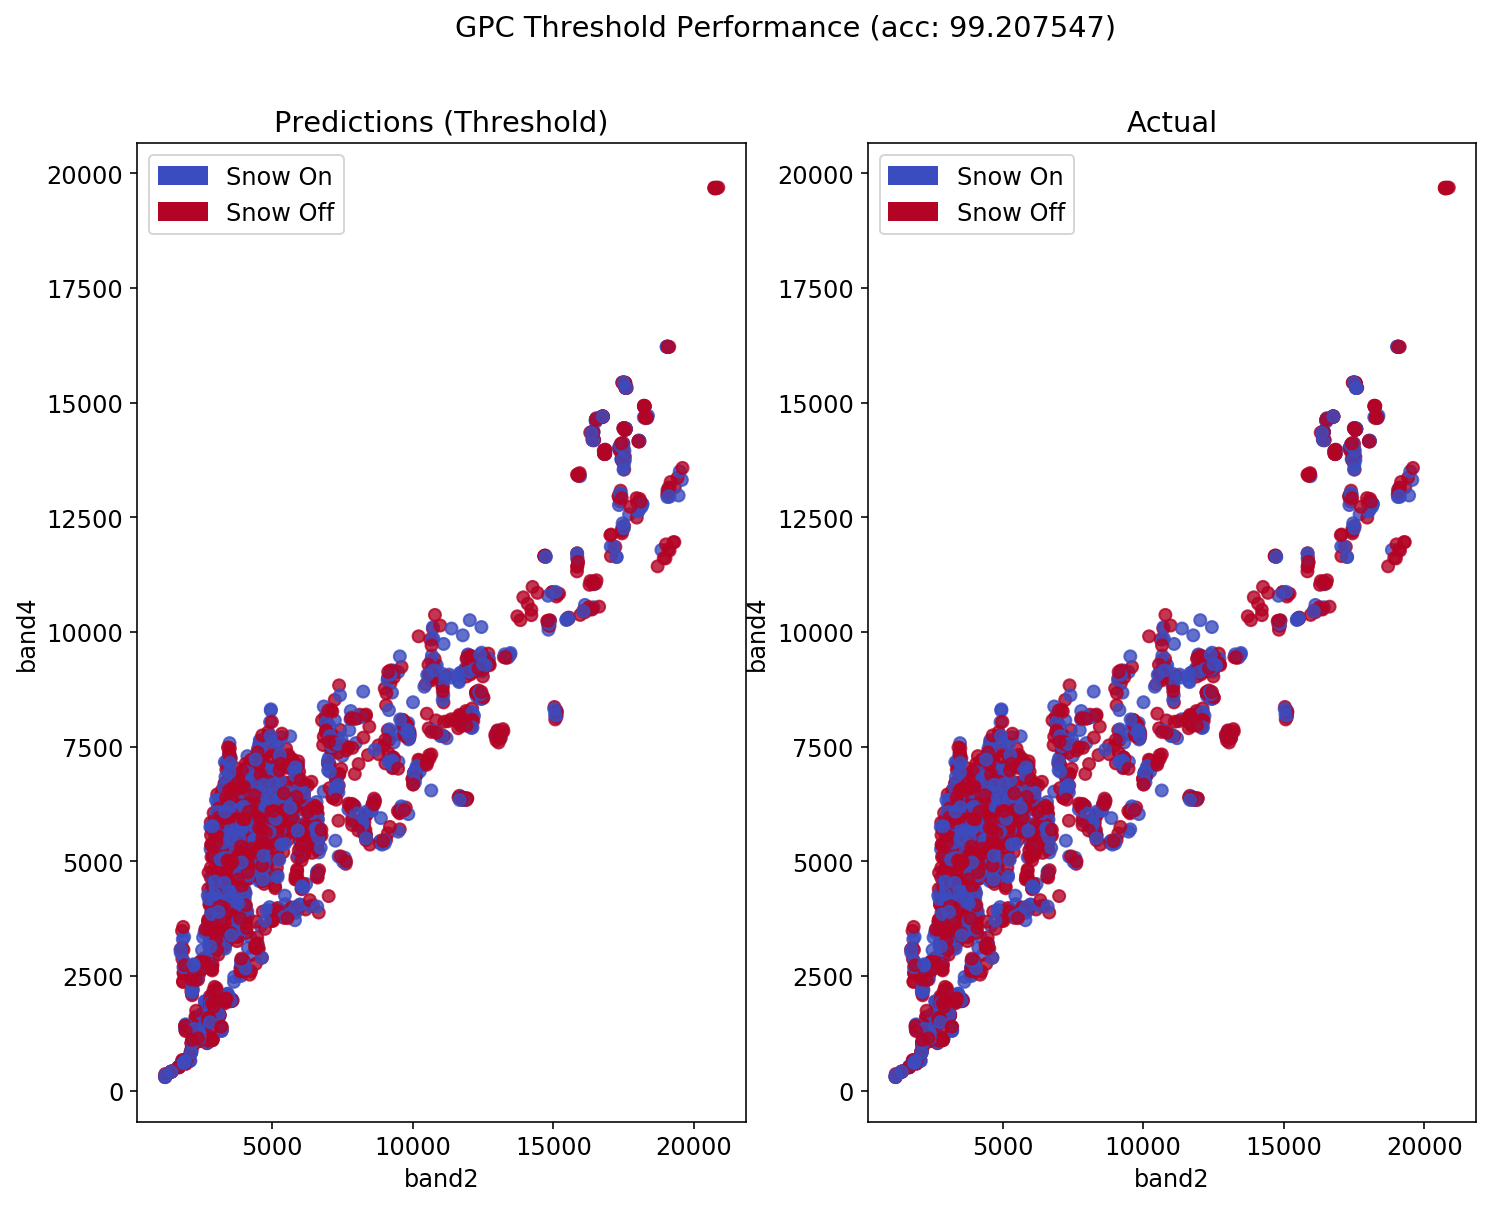

In [277]:
# which bands to plot?
b1 = 'band2'
b2 = 'band4'
preds = actualPreds

cmap = plt.get_cmap("coolwarm_r")

binary_colors = np.array([cmap(0), cmap(1)])

fig, (ax1, ax2) = plt.subplots(1, 2)
s1 = ax1.scatter(data[b1], data[b2], c = preds, cmap=cmap, alpha=0.8, vmin=0, vmax=1)
ax1.set_title("Predictions (Threshold)")
ax1.set_xlabel(b1)
ax1.set_ylabel(b2)
#plt.colorbar(s1, ax=ax1, orientation='horizontal')

ax2.scatter(data[b1], data[b2], c = y, cmap=cmap, alpha=0.8)
ax2.set_title("Actual")
ax2.set_xlabel(b1)
ax2.set_ylabel(b2)

nosnow_patch = patches.Patch(color=cmap(0.999999), label="Snow On")
snow_patch = patches.Patch(color=cmap(0), label='Snow Off')

ax1.legend(handles=[nosnow_patch, snow_patch])
ax2.legend(handles=[nosnow_patch, snow_patch])

# incorrect = abs(preds - merged.label)
# ax3.set_title("Mistakes")
# ax3.scatter(merged[b1], merged[b2], color=colors[incorrect], alpha=0.9)
# right_patch = patches.Patch(color=colors[0], label="Correct")
# wrong_patch = patches.Patch(color=colors[1], label='Incorrect')

# ax1.legend(handles=[nosnow_patch, snow_patch])
# ax2.legend(handles=[nosnow_patch, snow_patch])
# ax3.legend(handles=[right_patch, wrong_patch])

fig.suptitle("GPC Threshold Performance (acc: {:f})".format(accuracy * 100))

#plt.tight_layout(w_pad=0.9)



Text(0.5,0.98,'GPC Threshold Performance (subdomain)')

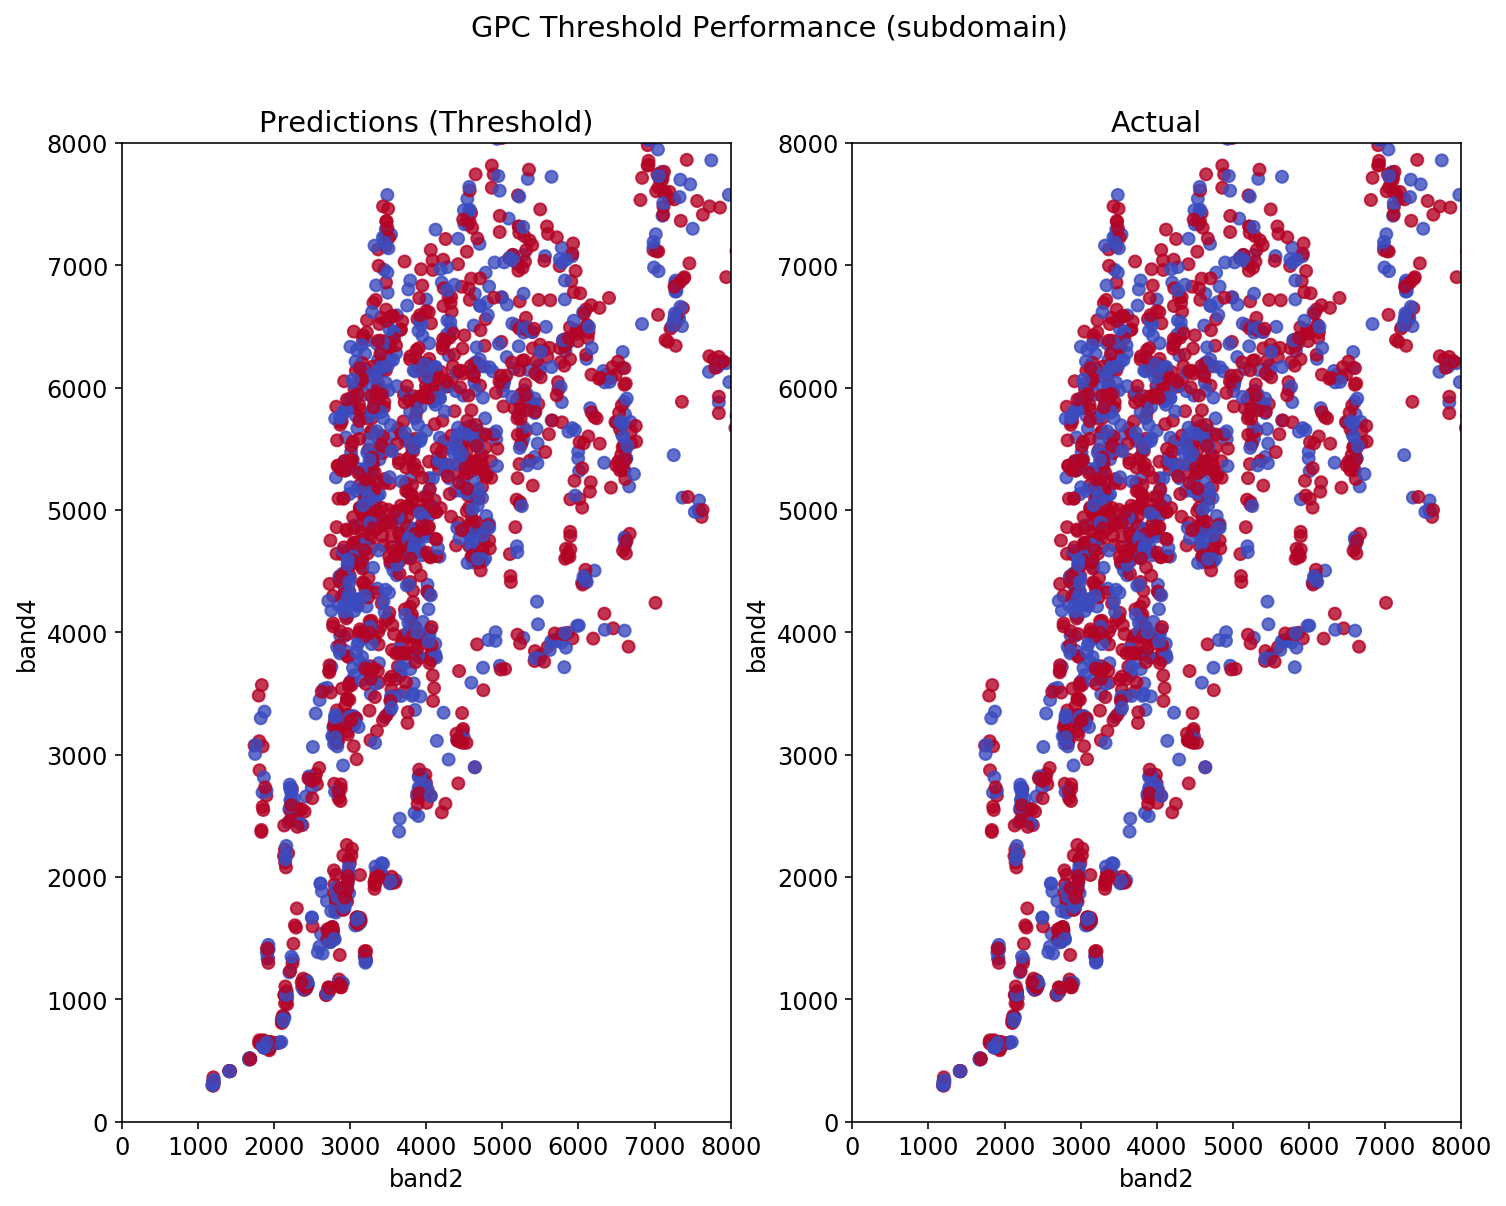

In [274]:
# which bands to plot?
b1 = 'band2'
b2 = 'band4'
preds = actualPreds

cmap = plt.get_cmap("coolwarm_r")

binary_colors = np.array([cmap(0), cmap(1)])

fig, (ax1, ax2) = plt.subplots(1, 2)
s1 = ax1.scatter(data[b1], data[b2], c = preds, cmap=cmap, alpha=0.8, vmin=0, vmax=1)
ax1.set_title("Predictions (Threshold)")
ax1.set_xlabel(b1)
ax1.set_ylabel(b2)
ax1.set_xlim(0, 8000)
ax1.set_ylim(0, 8000)

ax2.scatter(data[b1], data[b2], c = y, cmap=cmap, alpha=0.8)
ax2.set_title("Actual")
ax2.set_xlim(0, 8000)
ax2.set_ylim(0, 8000)
ax2.set_xlabel(b1)
ax2.set_ylabel(b2)

fig.suptitle("GPC Threshold Performance (subdomain)")

#plt.tight_layout()

## Recap + Next Steps
Pretty good performance. Plots look good. Model is saved in a file. 

Really good possibility for over-fitting here. Not totally sure how that's gonna work out in the long run. Next steps are to build a pipeline to add this info to imagery overlay and see what we see. 